## Load and Explore Data

In [2]:
import pandas as pd

In [3]:
file_path = "data.csv"
df = pd.read_csv(file_path, encoding="latin1")

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [5]:
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [6]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Handling Missing Values

In [7]:
df = df.dropna(subset=["CustomerID"])

In [8]:
num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

<ipython-input-8-37d3ab06efef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [9]:
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


## Feature Engineering: RFM Analysis

In [10]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [11]:
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [12]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [13]:
print((df['Quantity'] < 0).sum(), (df['UnitPrice'] < 0).sum())

0 0


In [14]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

<ipython-input-14-d32c111d07f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [15]:
import datetime

In [16]:
reference_date = df["InvoiceDate"].max() + datetime.timedelta(days=1)

In [17]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

In [18]:
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


## Removing Outliers

In [19]:
import numpy as np

In [20]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [21]:
for col in ["Monetary", "Frequency", "Recency"]:
    rfm = remove_outliers(rfm, col)

In [22]:
print(f"Dataset shape after outlier removal: {df.shape}")

Dataset shape after outlier removal: (397884, 9)


## Scaling Numerical Features

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
num_features = ["Recency", "Frequency", "Monetary"]

In [25]:
scaler = StandardScaler()
rfm[num_features] = scaler.fit_transform(rfm[num_features])

In [26]:
print(rfm[num_features].describe())

            Recency     Frequency      Monetary
count  3.749000e+03  3.749000e+03  3.749000e+03
mean  -2.369108e-17  3.601043e-17  1.516229e-17
std    1.000133e+00  1.000133e+00  1.000133e+00
min   -9.989997e-01 -8.533048e-01 -1.069756e+00
25%   -7.838274e-01 -8.533048e-01 -7.181774e-01
50%   -4.121662e-01 -3.037361e-01 -3.522278e-01
75%    6.147925e-01  7.954015e-01  3.954901e-01
max    2.649149e+00  2.993677e+00  3.773394e+00


## Encoding Categorical Variables

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
if "Category" in df.columns:
    le = LabelEncoder()
    df["Category_Encoded"] = le.fit_transform(df["Category"])
    df.drop(columns=["Category"], inplace=True)

In [29]:
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  


In [31]:
print(rfm[["Recency", "Frequency", "Monetary"]].describe())

            Recency     Frequency      Monetary
count  3.749000e+03  3.749000e+03  3.749000e+03
mean  -2.369108e-17  3.601043e-17  1.516229e-17
std    1.000133e+00  1.000133e+00  1.000133e+00
min   -9.989997e-01 -8.533048e-01 -1.069756e+00
25%   -7.838274e-01 -8.533048e-01 -7.181774e-01
50%   -4.121662e-01 -3.037361e-01 -3.522278e-01
75%    6.147925e-01  7.954015e-01  3.954901e-01
max    2.649149e+00  2.993677e+00  3.773394e+00


In [32]:
print(f"Unique customers: {df['CustomerID'].nunique()}")

Unique customers: 4338


## Visualizing Distributions

Recency Distribution

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

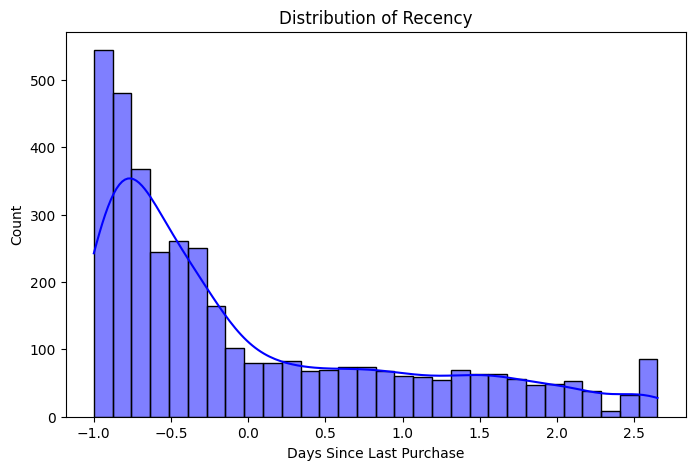

In [35]:
plt.figure(figsize=(8,5))
sns.histplot(rfm["Recency"], bins=30, kde=True, color="blue")
plt.title("Distribution of Recency")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Count")
plt.show()

Frequency Distribution

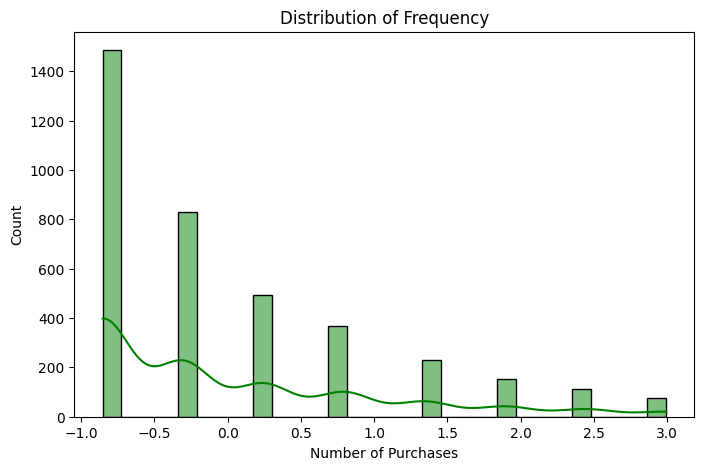

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(rfm["Frequency"], bins=30, kde=True, color="green")
plt.title("Distribution of Frequency")
plt.xlabel("Number of Purchases")
plt.ylabel("Count")
plt.show()

Monetary Distribution

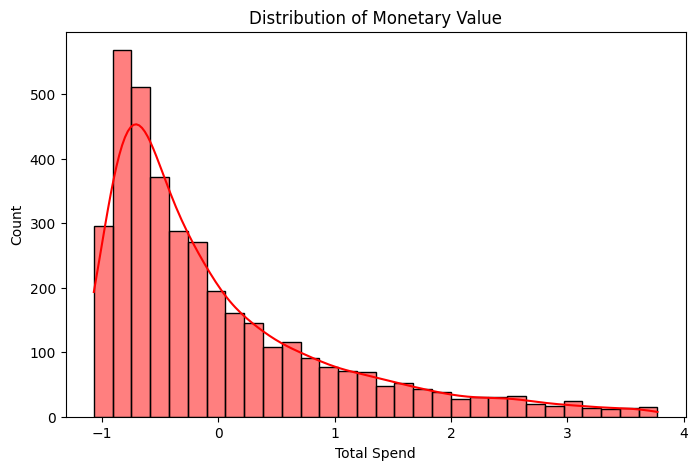

In [38]:
plt.figure(figsize=(8,5))
sns.histplot(rfm["Monetary"], bins=30, kde=True, color="red")
plt.title("Distribution of Monetary Value")
plt.xlabel("Total Spend")
plt.ylabel("Count")
plt.show()

## Correlation Analysis

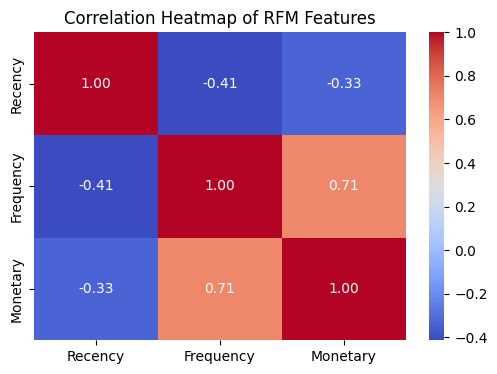

In [39]:
plt.figure(figsize=(6,4))
sns.heatmap(rfm[["Recency", "Frequency", "Monetary"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of RFM Features")
plt.show()

## Normalize Data for Clustering

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
num_features = ["Recency", "Frequency", "Monetary"]

In [46]:
scaler = StandardScaler()
rfm[num_features] = scaler.fit_transform(rfm[num_features])

In [47]:
print(rfm[num_features].describe())

            Recency     Frequency      Monetary
count  3.749000e+03  3.749000e+03  3.749000e+03
mean  -2.132197e-17  1.895286e-17  1.516229e-17
std    1.000133e+00  1.000133e+00  1.000133e+00
min   -9.989997e-01 -8.533048e-01 -1.069756e+00
25%   -7.838274e-01 -8.533048e-01 -7.181774e-01
50%   -4.121662e-01 -3.037361e-01 -3.522278e-01
75%    6.147925e-01  7.954015e-01  3.954901e-01
max    2.649149e+00  2.993677e+00  3.773394e+00


## K-Means Clustering

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [49]:
inertia = []
K_range = range(1, 11)

In [51]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm[num_features])
    inertia.append(kmeans.inertia_)

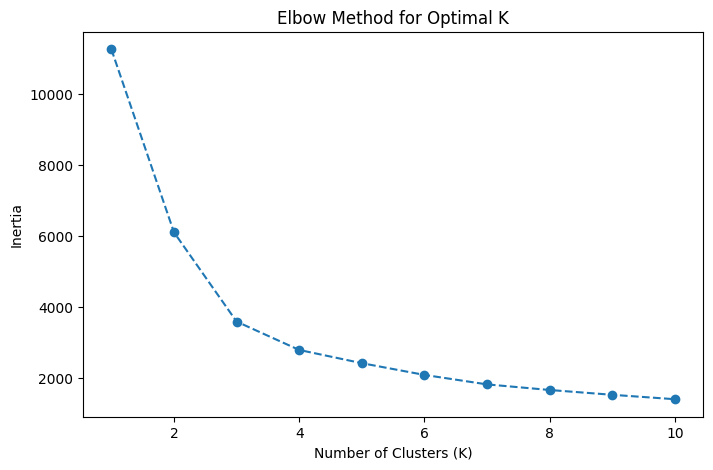

In [52]:
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [53]:
optimal_k = 4

In [56]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster_KMeans"] = kmeans.fit_predict(rfm[num_features])

In [57]:
print(rfm["Cluster_KMeans"].value_counts())

Cluster_KMeans
1    1490
2     933
3     876
0     450
Name: count, dtype: int64


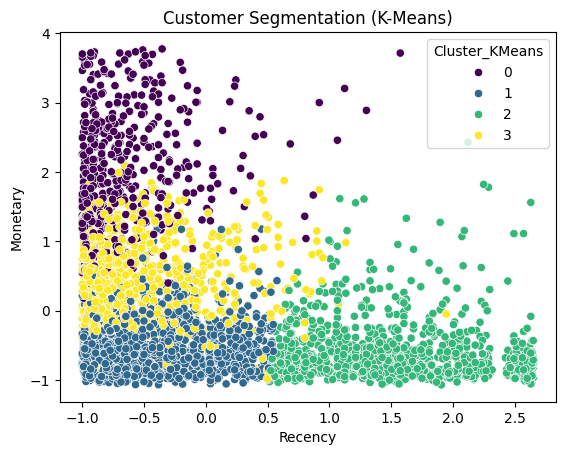

In [58]:
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["Cluster_KMeans"], palette="viridis")
plt.title("Customer Segmentation (K-Means)")
plt.show()

## Hierarchical Clustering

In [59]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

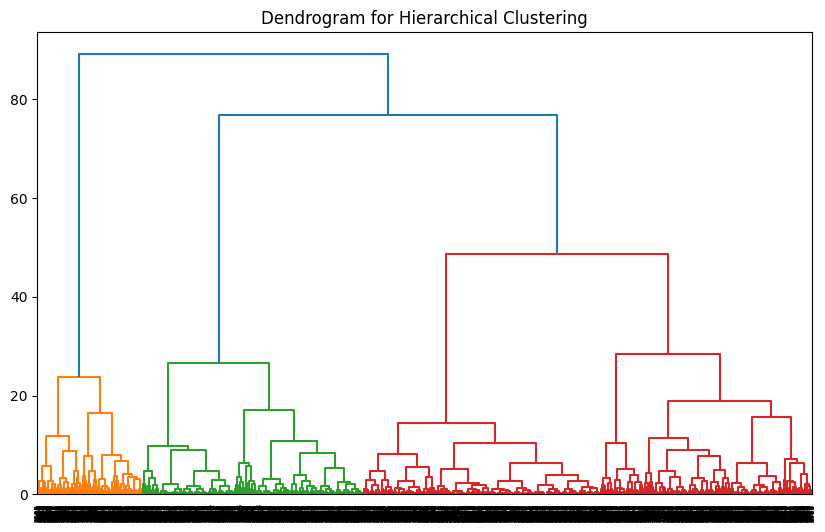

In [60]:
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(rfm[num_features], method="ward"))
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()

In [62]:
hc = AgglomerativeClustering(n_clusters=4, linkage="ward")
rfm["Cluster_HC"] = hc.fit_predict(rfm[num_features])

In [63]:
print(rfm["Cluster_HC"].value_counts())

Cluster_HC
3    1149
2    1067
0    1022
1     511
Name: count, dtype: int64


## DBSCAN Clustering

In [64]:
from sklearn.cluster import DBSCAN

In [65]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm["Cluster_DBSCAN"] = dbscan.fit_predict(rfm[num_features])

In [67]:
print(rfm["Cluster_DBSCAN"].value_counts())

Cluster_DBSCAN
 1    1477
 4     815
 3     489
 0     363
 5     220
 6     145
 7     111
 2      74
-1      49
 8       6
Name: count, dtype: int64


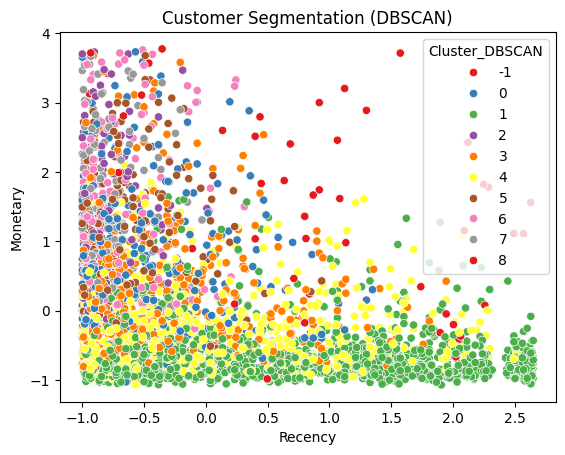

In [68]:
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["Cluster_DBSCAN"], palette="Set1")
plt.title("Customer Segmentation (DBSCAN)")
plt.show()

## Evaluate Clustering Models

In [69]:
from sklearn.metrics import silhouette_score

In [70]:
silhouette_kmeans = silhouette_score(rfm[num_features], rfm["Cluster_KMeans"])
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.3f}")

Silhouette Score (K-Means): 0.412


In [71]:
silhouette_hc = silhouette_score(rfm[num_features], rfm["Cluster_HC"])
print(f"Silhouette Score (Hierarchical): {silhouette_hc:.3f}")

Silhouette Score (Hierarchical): 0.362


In [73]:
if len(rfm["Cluster_DBSCAN"].unique()) > 1:
    silhouette_dbscan = silhouette_score(rfm[num_features], rfm["Cluster_DBSCAN"])
    print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.3f}")
else:
    print("DBSCAN did not find enough clusters for evaluation.")

Silhouette Score (DBSCAN): 0.069


In [74]:
from sklearn.metrics import davies_bouldin_score

In [75]:
dbi_kmeans = davies_bouldin_score(rfm[num_features], rfm["Cluster_KMeans"])
dbi_hc = davies_bouldin_score(rfm[num_features], rfm["Cluster_HC"])

print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans:.3f}")
print(f"Davies-Bouldin Index (Hierarchical): {dbi_hc:.3f}")

Davies-Bouldin Index (K-Means): 0.913
Davies-Bouldin Index (Hierarchical): 0.946


In [77]:
cluster_summary = rfm.groupby("Cluster_KMeans").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"
}).reset_index()

print(cluster_summary)

   Cluster_KMeans   Recency  Frequency  Monetary
0               0 -0.637988   1.789510  2.084343
1               1 -0.446949  -0.544956 -0.514083
2               2  1.527949  -0.658335 -0.578392
3               3 -0.539414   0.708826  0.419715
